In [2]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [3]:
import mpld3
mpld3.enable_notebook()
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
tar_scaler=preprocessing.StandardScaler()

df=pd.read_csv('v2_2.csv', sep=',',header=0)
labels=df['close']
df=df.drop(['Date','TickerName','open','high','low','volume'],axis=1)
labels_py=labels.to_numpy(dtype='float64')
labels_py=labels_py.reshape(-1,1)
#labels_py_scaled=tar_scaler.fit_transform(labels_py)
data=df.to_numpy(dtype='float64')
data_scaled=min_max_scaler.fit_transform(data)
print(len(data_scaled))
print(data_scaled.shape[-1])
print(labels_py)
print(data_scaled[:,23])


157208
24
[[1227.15]
 [1250.95]
 [1294.75]
 ...
 [ 714.9 ]
 [ 714.9 ]
 [ 714.9 ]]
[0.14546728 0.14829188 0.15349011 ... 0.08467294 0.08467294 0.08467294]


In [4]:
#GENERATOR
def generator(data,labels, lookback, delay, min_index, max_index,row_gen,
              shuffle=False, batch_size=128, step=6):
#shift the min and max indexes to incorporate the delay and lookback.
    print("inside gen")
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            #this condition starts drawing batches from the start again and the remaining data points are left as it is.
            if i + batch_size >= max_index:
                i = min_index + lookback
            #max index is involved here because while drawing the last batch, it should consider only the batch size.
            rows = np.arange(i, min(i + batch_size, max_index))
            #here i remembers the end index of the previous batch, so that next time the batch begins from here.
            i += len(rows)
    #rows here are just indices referring to the slice and the samples in the bigger picture.
    #lookback//step gives the timesteps for each samples or rows mentioned above.
    #data.shape[-1] gives us the columnar data: total 24.
        samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
        targets = np.zeros((len(rows),))
        r=np.zeros((len(rows),data.shape[-1]))

        for j, row in enumerate(rows):
            #print("inside loop")
        #indices here refers the indices or samples that serves as input to the particular jth sample.
        #in the next line, you can clearly see for the jth sample, you go back the lookback window, and take out
        #the sample that comes after step.
        #In a nutshell, all the 30 days ka data is not included from lookback window, the data is included after a period of step.
        #It makes sense because for N AND N+1th sample most of the lookback data will be same, but with steps we dont have that problem.
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            #if(data[rows[j]+delay][23]-data[rows[j]][23]>=0):
            #    targets[j]=1
            #else:
            #    targets[j]=0
            if(labels[rows[j]][0]==0):
                print("in 0")
                targets[j]=0
            else:
                
                targets[j]=(labels[rows[j]+delay][0]-labels[rows[j]][0])/labels[rows[j]][0]
            #the below comment is for prediction
            #targets[j] = data[rows[j] + delay][23]
            r[j]=data[rows[j]]

        #print(samples)
        #scale the targets now
        targets=np.reshape(targets,(-1,1))
        #standard scaler for this as it contains negative values
        targets=tar_scaler.fit_transform(targets)
        if(row_gen==True):
            yield samples,r, targets
        else:
            yield samples, targets

In [5]:
#Following the previous explanation, this makes total sense. FOr each sample, we will have 5 input rows and 1 output row.
#the shape of a sample will be (5,24)
lookback = 30
step = 3
delay = 7
batch_size = 128


train_gen = generator(data_scaled,labels_py,lookback=lookback,delay=delay,min_index=0,max_index=100000,row_gen=False,shuffle=True,step=step,batch_size=batch_size)

val_gen = generator(data_scaled,labels_py,
lookback=lookback,
delay=delay,
min_index=100001,
max_index=125000,
row_gen=False,                    
step=step,
batch_size=batch_size)

test_gen = generator(data_scaled,labels_py,
lookback=lookback,
delay=delay,
min_index=125001,
max_index=None,
row_gen=False,                     
step=step,
batch_size=batch_size)

val_steps = 194
#(125000 - 100001 - lookback)
test_steps =250
#(len(data_scaled) - 125001 - lookback)

In [6]:
i=0
while True:
    try:
        samples,targets=next(train_gen)
        print(samples.shape)
        print(targets)
        i=i+1
        break
    except StopIteration:
        break
    
#total is 100000, so you would draw 100000/128 batches=781.25. In effect, you should draw 780.
#They should be 24999/128=195.3==194
#32208/128=251.6=250



inside gen
(128, 10, 24)
[[ 0.37371524]
 [-0.39483246]
 [ 0.88169212]
 [ 0.22856871]
 [-0.25373312]
 [ 1.2039707 ]
 [-0.38588039]
 [ 0.97506163]
 [ 0.13370296]
 [ 1.93813884]
 [ 0.2485075 ]
 [ 0.91227758]
 [ 0.11955373]
 [ 1.14445709]
 [-0.11907199]
 [-0.92056131]
 [-0.2544235 ]
 [ 0.08445465]
 [ 1.02736832]
 [ 0.37406422]
 [ 1.36516887]
 [ 1.68657402]
 [-0.27226081]
 [-1.01106183]
 [ 0.09365849]
 [ 0.52592989]
 [ 1.01224894]
 [-0.25930244]
 [-2.91635892]
 [-0.88862326]
 [-0.63971978]
 [ 3.85956574]
 [ 0.29744753]
 [-0.33497642]
 [ 1.51419062]
 [-0.18050811]
 [-0.5788699 ]
 [-0.39123043]
 [ 0.62809773]
 [-0.03272619]
 [ 0.36738191]
 [-0.39027148]
 [ 0.73391643]
 [ 0.63910586]
 [ 0.53757968]
 [-0.51614884]
 [-0.21936634]
 [-0.7614222 ]
 [-1.02746751]
 [ 1.0531527 ]
 [-0.15157157]
 [-0.38252071]
 [-1.15211835]
 [-0.42340644]
 [-0.81670211]
 [ 0.08277227]
 [ 0.03714884]
 [ 0.23761517]
 [ 0.58632225]
 [ 0.5954055 ]
 [-1.41712445]
 [ 0.39618551]
 [ 0.38962365]
 [ 0.26808924]
 [ 0.24916528]


In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
#model.add(layers.Embedding(24, 10))
model.add(layers.Dense(24, input_shape = (lookback//step, data_scaled.shape[-1])))

model.add(layers.LSTM(64, return_sequences = True))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(32))
model.add(layers.Dense(30))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(), loss='mae')

model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10, 24)            600       
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 64)            22784     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 30)                990       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 36,821
Trainable params: 36,821
Non-trainable params: 0
__________________________________________________

In [10]:
def infinite_sequence():
    num = 0
    while True:
        yield num
        num += 1
        
gen=infinite_sequence()
print(next(gen))
print(next(gen))

print(next(train_gen))

0
1
(array([[[2.74693633e-01, 2.87485279e-01, 2.84008326e-01, ...,
         8.27479806e-04, 8.19257732e-04, 1.65812164e-02],
        [2.72891565e-01, 2.79850234e-01, 2.89920556e-01, ...,
         8.42776769e-04, 8.31627137e-04, 1.51095722e-02],
        [2.98898094e-01, 2.83699632e-01, 2.98624677e-01, ...,
         8.43177913e-04, 8.21669366e-04, 1.48054522e-02],
        ...,
        [2.09307875e-01, 3.11782621e-01, 3.13379071e-01, ...,
         8.56160396e-04, 8.37953576e-04, 1.55442413e-02],
        [1.64256063e-01, 2.80401442e-01, 3.03566266e-01, ...,
         8.09320133e-04, 8.22461749e-04, 1.55383073e-02],
        [1.36502549e-01, 2.37261970e-01, 2.86829342e-01, ...,
         8.18813877e-04, 8.35045652e-04, 1.58394602e-02]],

       [[1.29665317e-01, 1.78606544e-01, 1.82202930e-01, ...,
         6.99771318e-04, 5.46666710e-04, 2.17401100e-03],
        [1.10885202e-01, 1.67814952e-01, 1.68960266e-01, ...,
         7.10900029e-04, 5.39160319e-04, 2.23177493e-03],
        [9.15815666e

In [11]:
#steps per epoch might refer to the no of times the generator is called. // It is true.

history = model.fit(train_gen,
steps_per_epoch=780,
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

Epoch 1/20
780/780 [==============================] - 9s 7ms/step - loss: 0.6511 - val_loss: 0.7600
Epoch 2/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6519 - val_loss: 0.7600
Epoch 3/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6479 - val_loss: 0.7600
Epoch 4/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6535 - val_loss: 0.7600
Epoch 5/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6486 - val_loss: 0.7600
Epoch 6/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6547 - val_loss: 0.7600
Epoch 7/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6470 - val_loss: 0.7600
Epoch 8/20
780/780 [==============================] - 5s 7ms/step - loss: 0.6501 - val_loss: 0.7600
Epoch 9/20
780/780 [==============================] - 5s 6ms/step - loss: 0.6424 - val_loss: 0.7600
Epoch 10/20
780/780 [==============================] - 6s 7ms/step - loss: 0.6490 - val_loss: 0.7600

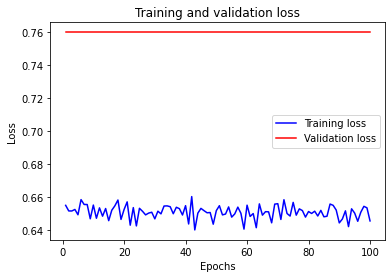

In [29]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, 101)

plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_scores = model.evaluate(test_gen,steps=test_steps, verbose=1)


inside gen
250/250 [==============================] - 1s 3ms/step - loss: 0.7561


In [11]:
preds=model.predict(test_gen,steps=250,verbose=1)

250/250 [==============================] - 1s 3ms/step


In [12]:
test_gen_excel = generator(data_scaled,
labels_py,
lookback=lookback,
delay=delay,
min_index=125001,
max_index=None,
row_gen=True,                           
step=step,
batch_size=batch_size)

In [13]:
print(preds)

#preds_unscaled=min_max_scaler.inverse_transform(preds)
steps=test_steps
whole_samples,whole_rows,whole_targets=next(test_gen_excel)
print(whole_rows.shape)
for i in range(steps-1):
    samples,row,targets=next(test_gen_excel)
    whole_samples=np.concatenate((whole_samples,samples),axis=0)
    whole_targets=np.concatenate((whole_targets,targets),axis=0)
    whole_rows=np.concatenate((whole_rows,row),axis=0)
    

#whole=np.concatenate((whole,preds),axis=1)
#print(whole)
#preds=preds.flatten()    
print(whole_samples)
whole_targets=np.reshape(whole_targets,(whole_targets.shape[0],1))
print(whole_targets)
print(whole_rows)
#print(preds_unscaled)

[[3.9597987e-09]
 [3.9619370e-09]
 [3.9638417e-09]
 ...
 [4.0488195e-09]
 [4.0527830e-09]
 [4.0574237e-09]]
inside gen
(128, 24)
[[[0.39005947 0.58377108 0.63845873 ... 0.00338342 0.00287608 0.00540592]
  [0.30212373 0.44785958 0.60134918 ... 0.00338395 0.00282311 0.0052457 ]
  [0.34550348 0.35045628 0.53006121 ... 0.00320099 0.00264676 0.00393427]
  [0.32151246 0.3409788  0.46161654 ... 0.00301472 0.00269687 0.00483032]
  [0.22072444 0.32324331 0.37582098 ... 0.00314358 0.00283258 0.00515669]]

 [[0.36717665 0.5644505  0.63580605 ... 0.00338215 0.00283078 0.00522196]
  [0.29762913 0.42426278 0.59090561 ... 0.00337918 0.00270308 0.00502021]
  [0.36236035 0.34559461 0.5182906  ... 0.00316963 0.00264854 0.00373252]
  [0.29797023 0.33980547 0.44769262 ... 0.00305739 0.00273549 0.00508548]
  [0.20496656 0.31537242 0.36304306 ... 0.00315139 0.00285227 0.00488966]]

 [[0.34854944 0.54370943 0.63166824 ... 0.00339619 0.00281386 0.00534658]
  [0.29900356 0.40286462 0.57958171 ... 0.00334638 0.

In [14]:
print(len(whole_targets))
print(len(preds))

32000
32000


In [15]:
#unscaling
#preds=preds.reshape(-1,1)

print(preds)
preds=tar_scaler.inverse_transform(preds)
print(preds)
whole_targets=tar_scaler.inverse_transform(whole_targets)
whole_rows=tar_scaler.inverse_transform(whole_rows)
print(whole_targets)

[[3.9597987e-09]
 [3.9619370e-09]
 [3.9638417e-09]
 ...
 [4.0488195e-09]
 [4.0527830e-09]
 [4.0574237e-09]]
[[-0.00680434]
 [-0.00680434]
 [-0.00680434]
 ...
 [-0.00680434]
 [-0.00680434]
 [-0.00680434]]
[[-0.02076952]
 [-0.06560567]
 [-0.04542274]
 ...
 [-0.02768694]
 [-0.00326319]
 [ 0.02805797]]


In [22]:
print(preds[60])
print(whole_targets[60])

[-0.00680434]
[0.24970654]


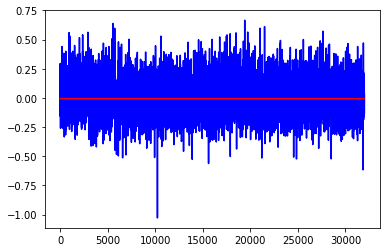

In [21]:
ran=range(32000)
#preds=preds.tolist('float64')
#preds.append(0)
plt.plot(ran, whole_targets, 'b', label='True')
plt.plot(ran, preds, 'r', label='Preds')
#plt.title('Truth and Preds')
#plt.xlabel('steps')
#plt.ylabel('close')
#plt.legend()
plt.show()